# ASSIGNMENT 3 - GRAB CUT IMPLEMENTATION

Submitted By- Anjali Bhatnagar 2019201012

Let us start with importing the packages

In [1]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import os
import sys
import math
import cv2 
import igraph as ig
from sklearn.mixture import GaussianMixture

Now we will define the various functions that we will be using to implement grab cut

## Modified Boilerplate Code:

In [2]:
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """
    
    def __init__(self, flags, img, _mask, colors):
        
        self.FLAGS = flags
        self.ix = -1
        self.iy = -1
        self.img = img
        self.img2 = self.img.copy()
        self._mask = _mask
        self.COLORS = colors

    @property
    def image(self):
        return self.img
    
    @image.setter
    def image(self, img):
        self.img = img
        
    @property
    def mask(self):
        return self._mask
    
    @mask.setter
    def mask(self, _mask):
        self._mask = _mask
    
    @property
    def flags(self):
        return self.FLAGS 
    
    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags
    
    def handler(self, event, x, y, flags, param):

        # Draw the rectangle first
        if event == cv2.EVENT_RBUTTONDOWN:
            self.FLAGS['DRAW_RECT'] = True
            self.ix, self.iy = x,y

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        elif event == cv2.EVENT_RBUTTONUP:
            self.FLAGS['DRAW_RECT'] = False
            self.FLAGS['rect_over'] = True
            cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
            self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
            self.FLAGS['rect_or_mask'] = 0

        
        # Draw strokes for refinement 

        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                print('Draw the rectangle first.')
            else:
                self.FLAGS['DRAW_STROKE'] = True
                cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x,y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_STROKE'] == True:
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)


The code below takes an input image and follows these steps:
- It requires a bounding box to be drawn by the user to roughly segment out the foreground pixels
- It runs an initial min-cut optimization using the provided annotation
- The result of this optimization gives an initial segmentation 
- To further refine this segmentation, the user provides two kinds of strokes to aid the optimization
    - strokes on the background pixels
    - strokes on the foreground pixels
- The algorithm now utilizes this to refine the original segmentation

## Implementation of GrabCut:

In [3]:

class GrabC:
    
    def __init__(self, img,num=1):
        #initialising some variables
        self.k = 25 # The number of components in each GMM model TO BE changed for experimentation
        self.connection = 8#number of pixels to which a particular pixel is connected
        #storing the image
        self.img = np.asarray(img, dtype = np.float32)
        self.img2 = img
        self.useProbable=True
        self.inputProbable=False
        num_rows=self.img.shape[0]
        num_cols=self.img.shape[1]
        tot=num_rows*num_cols
        self.gamma = 50#to be used for experimentation
        self._mask = np.zeros([num_rows, num_cols], dtype = np.uint8) 
        self.gc_source = tot
        self.gc_sink = tot + 1
        self.beta = 0
        self.independent_runs=3#change here for experimentation
        self.calc_beta(self.img)
        self.calc_nearby_weight(self.img)
        
    def init_with_gmm(self):
        #for background pixels
        if(self.useProbable):
            #we wont input probable points (section 4) but we need them to implement graph cut
            self._bgd = np.where(np.logical_or(self._mask == 0,self._mask ==2))
            self.ProbableUsed=True
        else:
            self._bgd = np.where(np.logical_and(self._mask == 0,self._mask ==2))
            self.ProbableUsed=False
        #setting background pixels
        self._BGDpixels = self.img[self._bgd]
        self.BGD_GMM = GaussianMixture(n_components = self.k, covariance_type='full')
        self.BGD_GMM.fit(self._BGDpixels)
        #for foreground pixels
        if(self.useProbable):
            self._fgd = np.where(np.logical_or(self._mask == 1,self._mask==3))
            self.ProbableUsed=True
        else:
            self._fgd = np.where(np.logical_and(self._mask == 1,self._mask==3))
            self.ProbableUsed=False
        #setting foreground pixels
        self._FGDpixels = self.img[self._fgd]
        #creating the model
        self.FGD_GMM = GaussianMixture(n_components = self.k, covariance_type='full')
        self.FGD_GMM.fit(self._FGDpixels)
        #no need to return we are storing them in class variables 
    
    def calc_beta(self,img):
        beta = 0
        num_rows=img.shape[0]
        num_cols=img.shape[1]
        tot=num_rows*num_cols
        #left <------
        left_diff=img[:,1:]-self.img[:,:-1]
        left_diff_squared=left_diff*left_diff
        #storing left_diff_squared_sum
        l_sum=left_diff_squared.sum()
        #upleft (i.e. diagonal left upwards pixel)
        upleft_diff=img[1:,1:]-img[:-1, :-1]
        upleft_diff_squared=upleft_diff*upleft_diff
        #storing up left_diff_squared_sum
        ul_sum=upleft_diff_squared.sum()
        #up diff
        up_diff=img[1:,:]-img[:-1, :]
        up_diff_squared=up_diff*up_diff
        #storing up left_diff_squared_sum
        up_sum=up_diff_squared.sum()
        #upright
        upr_diff=img[1:,:-1]-img[:-1, 1:]
        upr_diff_squared=upr_diff*upr_diff
        #storing up left_diff_squared_sum
        upr_sum=upr_diff_squared.sum()
        if self.connection == 8:
            # The 1st column doesn't have left, upleft and the last column doesn't have upright
            # The first row doesn't have upleft, up and upright
            # The first and last pixels in the 1st row are removed twice
            
            beta = (l_sum + ul_sum + up_sum + upr_sum)*2.0
            div_diff=4*tot - 3*num_cols - 3*num_rows + 2.0
            self.beta = 1/(beta/div_diff)
        else:
            beta = (l_sum + up_sum)*2.0
            div_diff=2*tot - num_cols - num_rows + 2.0
            self.beta = 1/(beta / div_diff)
            
    def calc_nearby_weight(self,img):
        beta=-1*self.beta
        num_rows=img.shape[0]
        num_cols=img.shape[1]
        tot=num_rows*num_cols
        #left <------
        left_diff_squared=np.square(img[:,1:]-self.img[:,:-1])
        #storing left_diff_squared_sum
        l_sum=np.sum(left_diff_squared,axis=2)
        #upleft (i.e. diagonal left upwards pixel)
        upleft_diff_squared=np.square( img[1:,1:]-img[:-1, :-1])
        #storing up left_diff_squared_sum
        ul_sum=np.sum(upleft_diff_squared,axis=2)
        #up diff
        up_diff_squared=np.square(img[1:,:]-img[:-1, :])
        #storing up left_diff_squared_sum
        up_sum=np.sum(up_diff_squared,axis=2)
        #upright
        upr_diff_squared=np.square(img[1:,:-1]-img[:-1, 1:])
        #storing up left_diff_squared_sum
        upr_sum=np.sum(upr_diff_squared,axis=2)
        self.left_V = 5 * np.exp(beta * l_sum)
        self.upleft_V = 5 / np.sqrt(2) * np.exp(beta * ul_sum)
        self.up_V = 5 * np.exp(beta * up_sum)
        self.upright_V = 5 / np.sqrt(2) * np.exp(beta * upr_sum)
    
    def negative_log_likelihood(d, clf):
        meanv=clf.means_[idx]
        idx = clf.predict(d)
        mat1=clf.covariances_[idx]
        det=np.linalg.det(mat1)
        tran=np.transpose(d - clf.means_[idx])
        inver=np.linalg.inv(mat1)
        t = 0.5 * np.dot(np.dot(tran, inver), d - meanv)
        g = -np.log(clf.weights_[idx])
        return (0.5 * np.log(det) + t + g)

    def getPenalty(self, img ,clf):
        penalty = list()
        rows=img.shape[0]
        cols=img.shape[1]
        tr=img.shape[2]
        a_=list()
        inv_=list()
        mean_=list()
        wt=list()
        d=img.reshape(rows*cols,tr)
        idx = clf.predict(d)
        for ind in range(self.k):
            mean=clf.means_[ind]
            mat1=clf.covariances_[ind]
            det=np.linalg.det(mat1)
            inv=np.linalg.inv(mat1)
            inv_.append(inv)
            a_.append(0.5 * np.log(det))
            wt.append(-np.log(clf.weights_[ind]))
            mean_.append(mean)
        for i in range(len(idx)):
            trans=np.transpose(d[i] - mean_[idx[i]])
            b=0.5 * np.dot(np.dot(trans, inv_[idx[i]]),d[i] - mean_[idx[i]] )
            penalty.append(a_[idx[i]]+b+wt[idx[i]])
        penalty=np.array(penalty).reshape(rows,cols)
        return penalty
    
    def storeVertices(self):
        bgd_indexes = np.where(self._mask.reshape(-1) == 0)
        bgd_vertices=list()
        for i in bgd_indexes:
            bgd_vertices.append(img[i])
        fgd_indexes=np.where(self._mask.reshape(-1) == 1)
        for i in fgd_indexes:
            fgd_vertices.append(img[i])
        return bgd_vertices,fgd_vertices
        
    def construct_gcgraph(self):
        rows=self.img.shape[0]
        cols=self.img.shape[1]
        #creating a list to store the edges
        edges = list()
        #for capacity
        self.graph_capacity = list()
        #background indices
        bgd_indexes = np.where(self._mask.reshape(-1) == 0)
        #foreground indices
        fgd_indexes = np.where(self._mask.reshape(-1) == 1)
        #probable indices_section 4
        pr_indexes = np.where(np.logical_or(self._mask.reshape(-1) == 2,self._mask.reshape(-1) == 3))
        start_point=pr_indexes[0]
        nump=pr_indexes[0].size#storing number of probable points
        numb=bgd_indexes[0].size#storing number of background points
        numf=fgd_indexes[0].size#storing number of foreground points
        ### Adding Sink ,Source Nodes
        iterators=zip([self.gc_source]*nump,start_point)
        iterators_list=list(iterators)
        #appending in edges
        for i in iterators_list:
            edges.append(i)
        #edges.extend(list(zip([self.gc_source] * pr_indexes[0].size, pr_indexes[0])))
        bg_pen = self.bg_penalty.reshape(-1)
        fg_pen = self.fg_penalty.reshape(-1)
        bg_pen = bg_pen[pr_indexes]
        fg_pen = fg_pen[pr_indexes]
        bg_pen=list(bg_pen)
        bg_start=bgd_indexes[0]
        fg_start=fgd_indexes[0]
        for i in bg_pen:
            self.graph_capacity.append(i)
        #source done 
        #lets move to sink
        iterator2=zip([self.gc_sink]*nump,start_point)
        iterators_lis=list(iterator2)
        #appending in edges
        for i in iterators_lis:
            edges.append(i)
        for i in fg_pen:
            self.graph_capacity.append(i)
        e =time.time()
        #lets again extend the graph now for bgd
        iterato=zip([self.gc_source] * numb, bg_start)
        iterato=list(iterato)
        for i in iterato:
            edges.append(i)
        #extending graph capacity now
        self.graph_capacity.extend([0] * numb)
        #source bg done lets do for sink
        iterato=zip([self.gc_sink] * numb, bg_start)
        iterato=list(iterato)
        for i in iterato:
            edges.append(i)
        self.graph_capacity.extend([45] * numb)#9 * 5
        #lets extend for fg
        iterato=zip([self.gc_source] * numf, fg_start)
        iterato=list(iterato)
        for i in iterato:
            edges.append(i)
        self.graph_capacity.extend([45] * numf)
        iterato=zip([self.gc_sink] * numf, fg_start)
        iterato=list(iterato)
        for i in iterato:
            edges.append(i)
        self.graph_capacity.extend([0] * numf)

        ### Adding pixel nodes 
        
        #Give edge weights to links which are with left node
        img_indexes = np.arange(rows*cols,dtype=np.uint32).reshape(rows,cols)
        temp1 = img_indexes[:, 1:]
        mask1 = temp1.reshape(-1)
        temp2 = img_indexes[:, :-1]
        mask2 = temp2.reshape(-1)
        # Give edge weights to links which are with the upper nodes(pixels)
        temp3 = img_indexes[1:, :]
        mask3 = temp1.reshape(-1)
        temp4 = img_indexes[:-1, :]
        mask4 = temp2.reshape(-1)
        ite=zip(mask1,mask2)
        itr=zip(mask3,mask4)
        ite=list(ite)
        for i in ite:
            edges.append(i)
        itr=list(itr)
        for i in itr:
            edges.append(i)
        #extending self graph
        lV=self.left_V.reshape(-1)
        uV=self.up_V.reshape(-1)
        lV=lV.tolist()
        uV=uV.tolist()
        for i in lV:
            self.graph_capacity.append(i)
        for i in uV:
            self.graph_capacity.append(i)
        #self.graph_capacity.extend(self.left_V.reshape(-1).tolist())
        #self.graph_capacity.extend(self.up_V.reshape(-1).tolist())
        #while experimenting change code from here 
        if self.connection == 8 :
            ## Give edge weights to links which are with upper-left node
            temp1 = img_indexes[1:, 1:]
            mask1 = temp1.reshape(-1)
            temp2 = img_indexes[:-1, :-1]
            mask2 = temp2.reshape(-1)
            # Give edge weights to links which are with the upper nodes(pixels)
            temp3 = img_indexes[1:, :-1]
            mask3 = temp1.reshape(-1)
            temp4 = img_indexes[:-1, 1:]
            mask4 = temp2.reshape(-1)
            ite=zip(mask1,mask2)
            itr=zip(mask3,mask4)
            ite=list(ite)
            for i in ite:
                edges.append(i)
            itr=list(itr)
            for i in itr:
                edges.append(i)
            #extending self graph
            lV=self.upleft_V.reshape(-1)
            uV=self.upright_V.reshape(-1)
            lV=lV.tolist()
            uV=uV.tolist()
            for i in lV:
                self.graph_capacity.append(i)
            for i in uV:
                self.graph_capacity.append(i)
            #self.graph_capacity.extend(self.upleft_V.reshape(-1).tolist())
            #self.graph_capacity.extend(self.upright_V.reshape(-1).tolist())
        #networkx slower than iGraph takes more time
        self.graph = ig.Graph(cols * rows + 2)
        #adding edges
        self.graph.add_edges(edges)
        
    def findprobableindices(self):
        #check for the various flags and then return 
        if(self.useProbable):
            return np.where(np.logical_or(self._mask == 2, self._mask == 3))
        else:
            return list()
            

    def estimate_segmentation(self):
        print("Estimating Segmentation",end=" ")
        rows=self.img.shape[0]
        cols=self.img.shape[1]
        tot=rows*cols
        source_size=tot
        sink_size=tot+1
        #performing mincut
        mincut = self.graph.st_mincut(self.gc_source,self.gc_sink, self.graph_capacity)
        print("Performed Mincut",end=" ")
        #getting the probable indices
        img_indexes = np.arange(rows * cols,dtype=np.uint32).reshape(rows, cols)
        pr_indexes = self.findprobableindices()
        if(len(pr_indexes)>0):
             self._mask[pr_indexes] = np.where(np.isin(img_indexes[pr_indexes], mincut.partition[0]),3, 2)
        
    
    def run(self ,mask=None ,rect=None ,ismask =False,prin_f=False):
        
        if ismask==False:
            #masking everything inside the rec to probable foreground
            x_start=rect[1]
            x_end=rect[1]+rect[3]
            y_start=rect[0]
            y_end=rect[0]+rect[2]
            #as everything inside the rectangle is probable background let us shrink the rectangle
            x_start+=3
            y_start+=3
            x_end-=3
            y_end-=3
            self._mask[x_start:x_end, y_start:y_end] = 3
            #we are masking it here this is the reason we need probale points as true (set flag true in init)
            print('Starting The GMM modelling ! ',end=" ")
            self.init_with_gmm()
        else:
            self._mask = mask
        if(prin_f):
            print("Lets begin with the Iterations of Grab Cut")
            print("Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation")
        #iter_results=list()
        for i in range(self.independent_runs):
            #getting the penalty
            self.init_with_gmm()
            self.fg_penalty = self.getPenalty(self.img, self.FGD_GMM)
            print('Iteration Number:',i)
            self.bg_penalty = self.getPenalty(self.img, self.BGD_GMM)
            print('Constructing Graph;',end=" ")
            self.construct_gcgraph()
            print('Graph Constructed;',end=" ")
            print('Estimating Seg;',end=" ")
            self.estimate_segmentation() 
            print('Iteration  done;')
        print('Time for user interaction :p :p')

In [4]:
def run(filename: str,answers,color_space=1):
    
    COLORS = {'BLACK' : [0,0,0],'RED'   : [0, 0, 255],'GREEN' : [0, 255, 0],'BLUE'  : [255, 0, 0],'WHITE' : [255,255,255]}
    DRAW_BG = {'color' : [0,0,0], 'val' : 0}
    DRAW_FG = {'color' : [255,255,255], 'val' : 1}

    FLAGS = {
        'RECT' : (0, 0, 1, 1),
        'DRAW_STROKE': False,         # flag for drawing strokes
        'DRAW_RECT' : False,          # flag for drawing rectangle
        'rect_over' : False,          # flag to check if rectangle is  drawn
        'rect_or_mask' : -1,          # flag for selecting rectangle or stroke mode
        'value' : DRAW_FG,            # drawing strokes initialized to mark foreground
    }

    img = cv2.imread(filename)
    #for experimenting with color space 
    #color_space=4#for normal color space
    #converting to YCrCb 
    if color_space==2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    #converting to HSV
    if color_space==3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    #converting to LAB
    if color_space==4:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    img2 = img.copy() 
    mask = np.zeros(img.shape[:2], dtype = np.uint8)  
    output = np.zeros(img.shape, np.uint8)           

    # Input and segmentation windows
    cv2.namedWindow('Input Image')
    cv2.namedWindow('Segmented output')
    
    EventObj = EventHandler(FLAGS, img, mask, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)
    cv2.moveWindow('Input Image', img.shape[1] + 10, 90)
    
    GC = GrabC(img)
    while(1):
        
        img = EventObj.image
        mask = EventObj.mask
        FLAGS = EventObj.flags
        
        cv2.imshow('Segmented image', output)
        cv2.imshow('Input Image', img)
        
        k = cv2.waitKey(1)

        if k == 27:
            break
        
        elif k == ord('0'): 
            FLAGS['value'] = DRAW_BG
        
        elif k == ord('1'):
            FLAGS['value'] = DRAW_FG
                
        elif k == 13: 
            #13 is for enter 
            if FLAGS['rect_or_mask'] == 0:
                GC.run(mask ,FLAGS['RECT'] ,False ,True)
                FLAGS['rect_or_mask'] = 1
            elif FLAGS['rect_or_mask'] == 1:
                GC.run(mask , None , True,False)
        
            EventObj.flags = FLAGS
            #for probable foreground and foreground
            FGD = np.where((GC._mask == 1) + (GC._mask == 3), 255, 0).astype('uint8')
            output = cv2.bitwise_and(GC.img2, GC.img2, mask = FGD)
            img_out=cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
            answers.append(img_out)
            EventObj.mask = GC._mask
    return answers

## Running Grab Cut on certain Images

In [6]:
filename = '../images/sheep.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()

Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Iteration Number: 1
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Iteration Number: 2
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Iteration Number: 1
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Iteration Number: 2
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Ite

In [9]:
cv2.destroyAllWindows()

In [10]:
print(len(answers))

4


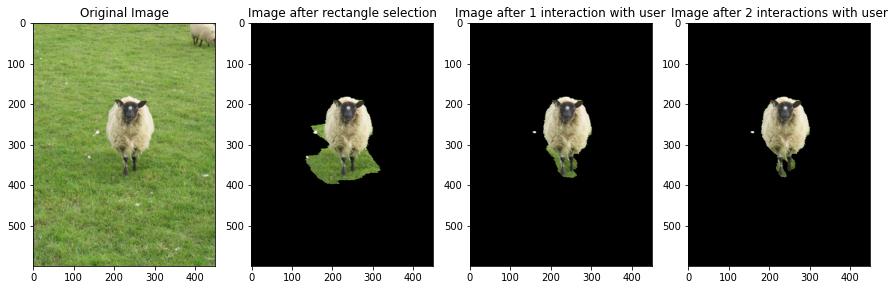

In [17]:
img = cv2.imread(filename)
org=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(org)
plt.title("Original Image")
plt.subplot(1,4,2)
plt.imshow(answers[1])
plt.title("Image after rectangle selection")
plt.subplot(1,4,3)
plt.imshow(answers[2])
plt.title("Image after 1 interaction with user")
plt.subplot(1,4,4)
plt.imshow(answers[3])
plt.title("Image after 2 interactions with user")
plt.show()

Now let us try increasing the number of iterations for grab cut and lets see the result :
    

In [8]:
filename = '../images/sheep.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()

Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Iteration Number: 1
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Iteration Number: 2
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p


We changed the iterations to 3 from 2 and lets see the difference. The above comparison shows the image after rectangle selection. This particular image that we got without any human interaction just by increasing the number of iterations is better then that we got previously.

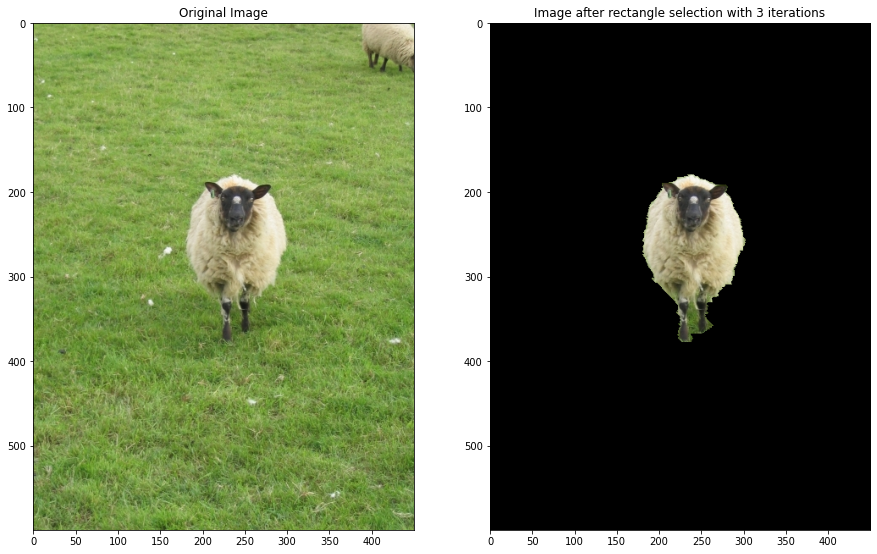

In [9]:
img = cv2.imread(filename)
org=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(org)
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(answers[0])
plt.title("Image after rectangle selection with 3 iterations")
plt.show()

### Conclusion:

From the abpve results that we got after we ran the grab cut on the image of a sheep we can see that we achieve fairly good segmentation with this . However to further refine the segments that are obtained we have the user interaction mode in which I as a user marked some pixels as foreground (key 1) and some pixels as background (0). After that we see vast improvement in the results iteration after iteration.

-------------------------------------------------------------------------------------------------------------------
Now let us run Grab Cut on different images given us after that we will proceed with various experimentations on the code

In [21]:
filename = '../images/doll.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()

Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interacti

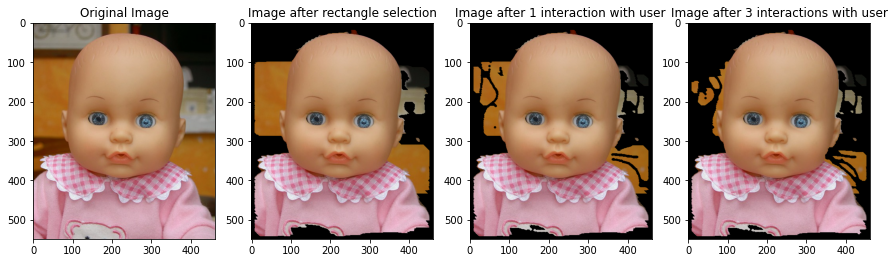

In [25]:
img = cv2.imread(filename)
org=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(org)
plt.title("Original Image")
plt.subplot(1,4,2)
plt.imshow(answers[0])
plt.title("Image after rectangle selection")
plt.subplot(1,4,3)
plt.imshow(answers[2])
plt.title("Image after 1 interaction with user")
plt.subplot(1,4,4)
plt.imshow(answers[4])
plt.title("Image after 3 interactions with user")
plt.show()

For this image as well we see the same inferences as we saw for the 1st image.

In [26]:
filename = '../images/flower.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()

Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p


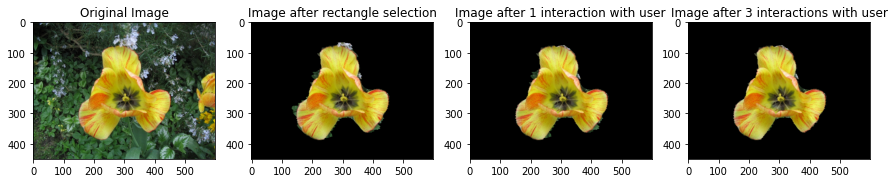

In [28]:
img = cv2.imread(filename)
org=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(org)
plt.title("Original Image")
plt.subplot(1,4,2)
plt.imshow(answers[0])
plt.title("Image after rectangle selection")
plt.subplot(1,4,3)
plt.imshow(answers[2])
plt.title("Image after 1 interaction with user")
plt.subplot(1,4,4)
plt.imshow(answers[3])
plt.title("Image after 3 interactions with user")
plt.show()

With the initial rectangle selection i.e. the region selection we did at step 1 we got pretty good results. Though we can see that after we performed the user interaction in which we marked some pixels as background and some pixels as foreground we got a perfectly segmented image in this case !

In [30]:
filename = '../images/music.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()

Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p


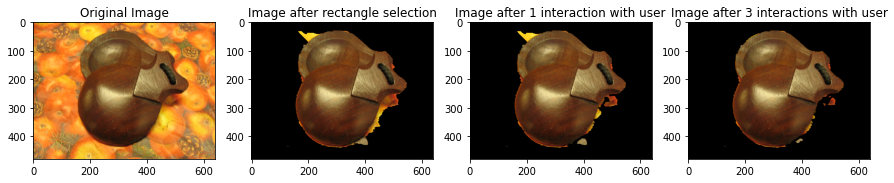

In [32]:
img = cv2.imread(filename)
org=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(org)
plt.title("Original Image")
plt.subplot(1,4,2)
plt.imshow(answers[0])
plt.title("Image after rectangle selection")
plt.subplot(1,4,3)
plt.imshow(answers[1])
plt.title("Image after 1 interaction with user")
plt.subplot(1,4,4)
plt.imshow(answers[3])
plt.title("Image after 3 interactions with user")
plt.show()

After performing grabcut we get a pretty good segmented image :D :) 

In [33]:
filename = '../images/teddy.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()

Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p


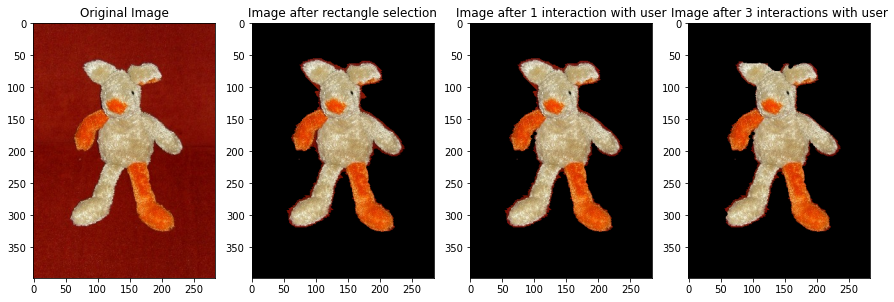

In [34]:
img = cv2.imread(filename)
org=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(org)
plt.title("Original Image")
plt.subplot(1,4,2)
plt.imshow(answers[0])
plt.title("Image after rectangle selection")
plt.subplot(1,4,3)
plt.imshow(answers[1])
plt.title("Image after 1 interaction with user")
plt.subplot(1,4,4)
plt.imshow(answers[3])
plt.title("Image after 3 interactions with user")
plt.show()

The image was well segmented after the initial step only . Perhaps the further iterations involving human iteration

In [35]:
filename = '../images/book.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()

Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interacti

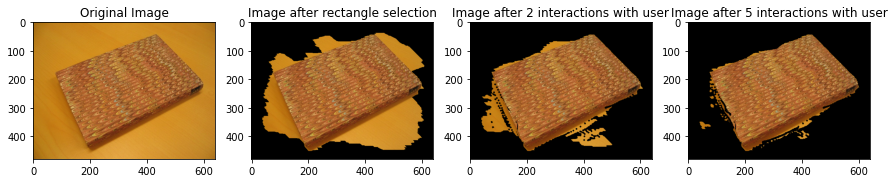

In [39]:
img = cv2.imread(filename)
org=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(org)
plt.title("Original Image")
plt.subplot(1,4,2)
plt.imshow(answers[0])
plt.title("Image after rectangle selection")
plt.subplot(1,4,3)
plt.imshow(answers[2])
plt.title("Image after 2 interactions with user")
plt.subplot(1,4,4)
plt.imshow(answers[5])
plt.title("Image after 5 interactions with user")
plt.show()

In this image after the initial segmentation that was done after the rectangle was marked we donot get a very good segmented object . Thus we iterate and mark bg and fg points which give us a well segmented object after 5 interactions.

In [40]:
filename = '../images/tennis.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()

Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interacti

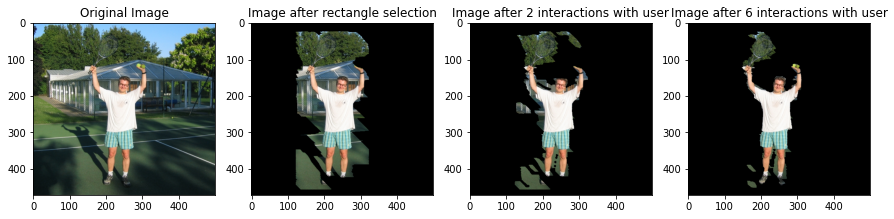

In [44]:
img = cv2.imread(filename)
org=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(org)
plt.title("Original Image")
plt.subplot(1,4,2)
plt.imshow(answers[0])
plt.title("Image after rectangle selection")
plt.subplot(1,4,3)
plt.imshow(answers[2])
plt.title("Image after 2 interactions with user")
plt.subplot(1,4,4)
plt.imshow(answers[5])
plt.title("Image after 6 interactions with user")
plt.show()

There is a close resemblance between some foreground pixels and some background pixels due to which initially many background pixels were classified as foreground object. Though with many human interactions we could get a pretty good foreground segmented object

#### Now let us start with the experimentation :

We need to analyse how changes in various parameters effect the segmentation.

## 1.Effect of a tight initial bounding box or a loose bounding box.

A tighter initial bounding box means that the the rectangle that we are forming is very close to the object of interest and contains majorly the foreground pixels.It results in a more stricter
supervision and thus a more accurate segmentation of the foreground object from the background.
A loose initial bounding box has many pixels which are not a part of the foreground but are a part of the background. It will result in a weaker supervision and hence a lot of background pixels would be
present in the region of interest which wouldn’t be learned as a part of background model and hence we won’t get a
very accurate segmentation.We came to this conclusion after seeing the results of various images and the size of the bounding box. Let us see the results on the following some images:

In [47]:
filename = '../images/sheep.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()

Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p


In [49]:
loose=answers[0]

In [50]:
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()

Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p


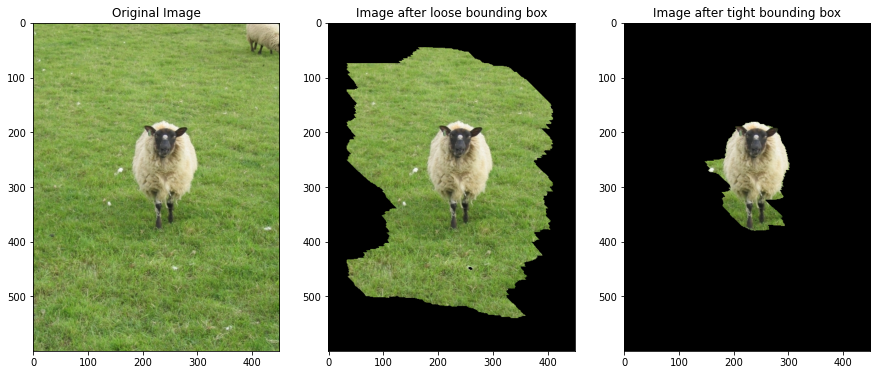

In [51]:
img = cv2.imread(filename)
org=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(org)
plt.title("Original Image")
plt.subplot(1,3,2)
plt.imshow(loose)
plt.title("Image after loose bounding box")
plt.subplot(1,3,3)
plt.imshow(answers[0])
plt.title("Image after tight bounding box")
plt.show()

We can see a vast difference in the segmented image if we choose a loose bounding box and if we choose a tight bounding box. The tight bounding box gives us pretty good results.

In [52]:
filename = '../images/teddy.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
loose=answers[0]
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()

Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p


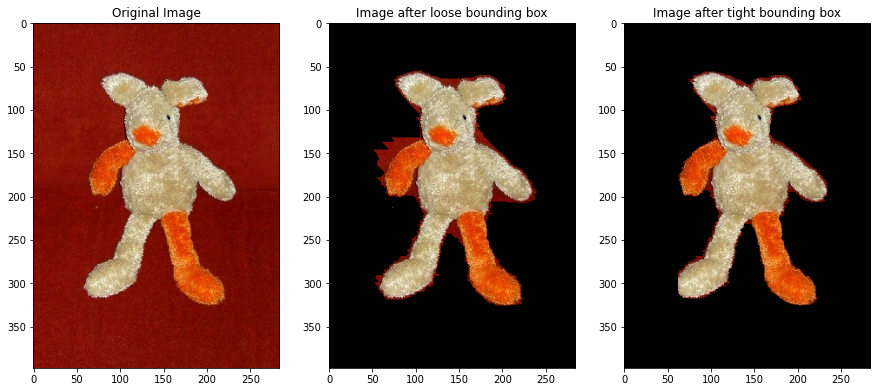

In [53]:
img = cv2.imread(filename)
org=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(org)
plt.title("Original Image")
plt.subplot(1,3,2)
plt.imshow(loose)
plt.title("Image after loose bounding box")
plt.subplot(1,3,3)
plt.imshow(answers[0])
plt.title("Image after tight bounding box")
plt.show()

In [54]:
filename = '../images/grave.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
loose=answers[0]
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()

Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Draw the rectangle first.
Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p


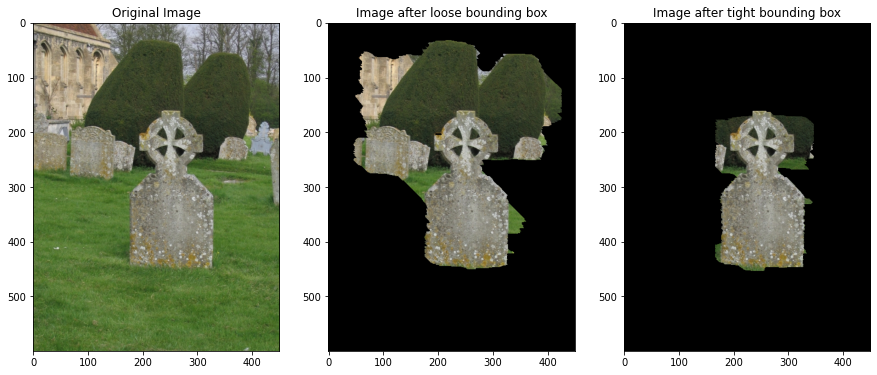

In [55]:
img = cv2.imread(filename)
org=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(org)
plt.title("Original Image")
plt.subplot(1,3,2)
plt.imshow(loose)
plt.title("Image after loose bounding box")
plt.subplot(1,3,3)
plt.imshow(answers[0])
plt.title("Image after tight bounding box")
plt.show()

In [56]:
filename = '../images/music.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
loose=answers[0]
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()

Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p


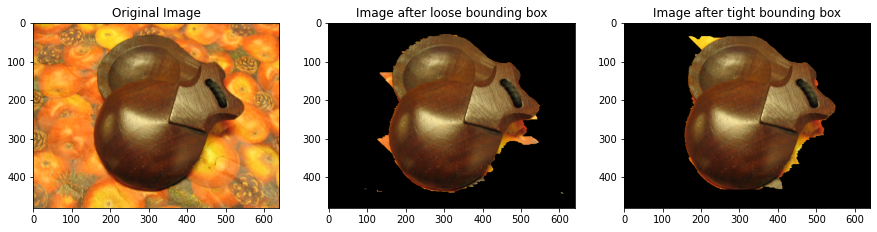

In [57]:
img = cv2.imread(filename)
org=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(org)
plt.title("Original Image")
plt.subplot(1,3,2)
plt.imshow(loose)
plt.title("Image after loose bounding box")
plt.subplot(1,3,3)
plt.imshow(answers[0])
plt.title("Image after tight bounding box")
plt.show()

In [58]:
filename = '../images/stone2.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
loose=answers[0]
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()

Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p


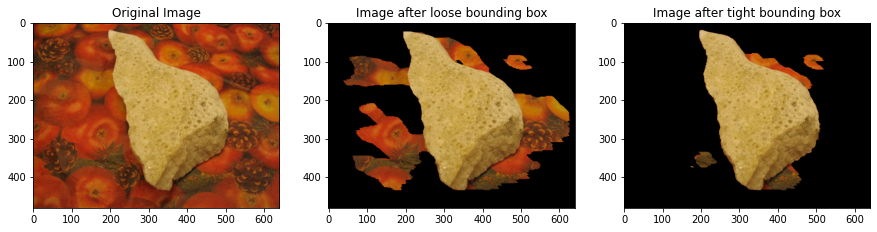

In [59]:
img = cv2.imread(filename)
org=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(org)
plt.title("Original Image")
plt.subplot(1,3,2)
plt.imshow(loose)
plt.title("Image after loose bounding box")
plt.subplot(1,3,3)
plt.imshow(answers[0])
plt.title("Image after tight bounding box")
plt.show()

### Conclusion :
    From this experiment we can conclude that we get better results for tight bounding boxes.

### 2.Effect of Different color spaces

Let us try this out on 2 to 3 images and see if we are getting any different results based on the color space that we are choosing :) 

In [62]:
filename = '../images/teddy.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
original=answers[0]

Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p


In [64]:
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
ycrcb=answers[0]

Draw the rectangle first.
Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p


In [66]:
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
hsv=answers[0]

Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p


In [68]:
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
lab=answers[0]

Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p


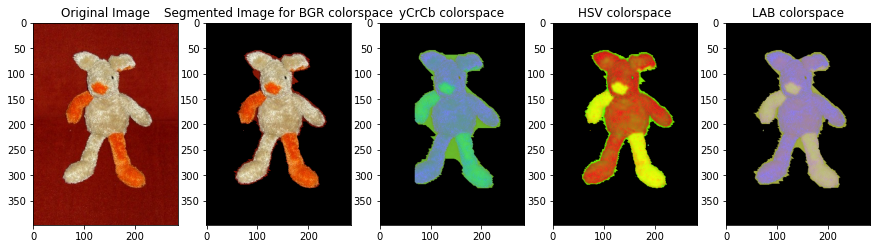

In [74]:
img = cv2.imread(filename)
org=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,15))
plt.subplot(1,5,1)
plt.imshow(org)
plt.title("Original Image")
plt.subplot(1,5,2)
plt.imshow(original)
plt.title("Segmented Image for BGR colorspace")
plt.subplot(1,5,3)
plt.imshow(ycrcb)
plt.title("yCrCb colorspace")
plt.subplot(1,5,4)
plt.imshow(hsv)
plt.title("HSV colorspace")
plt.subplot(1,5,5)
plt.imshow(lab)
plt.title("LAB colorspace")
plt.show()

In [75]:
filename = '../images/music.jpg'# Path to image file
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
lab=answers[0]

Draw the rectangle first.
Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p


In [77]:
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
original=answers[0]

Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p


In [78]:
answers=list()
answers=run(filename,answers,2)
cv2.destroyAllWindows()
ycrcb=answers[0]
answers=list()
answers=run(filename,answers,3)
cv2.destroyAllWindows()
hsv=answers[0]

Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p


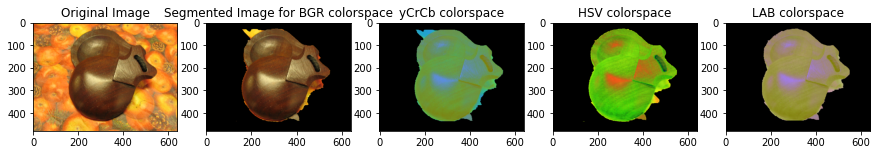

In [79]:
img = cv2.imread(filename)
org=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,15))
plt.subplot(1,5,1)
plt.imshow(org)
plt.title("Original Image")
plt.subplot(1,5,2)
plt.imshow(original)
plt.title("Segmented Image for BGR colorspace")
plt.subplot(1,5,3)
plt.imshow(ycrcb)
plt.title("yCrCb colorspace")
plt.subplot(1,5,4)
plt.imshow(hsv)
plt.title("HSV colorspace")
plt.subplot(1,5,5)
plt.imshow(lab)
plt.title("LAB colorspace")
plt.show()

### Conclusion:
    For the above 2 images we can say that the colorspace we use for the images does not have any noticable maj-or effect on the segmentated object we get. As a part of this experiment we tried the original colorspace (BGR), The yCrCb colorspace , the HSV colorspace and the LAB colorspsce and we got fairly the same results.
    Thus we can conclude this part of the experiment by saying that by changing the color space there is no ef-fect on the segmentation.

### 3. Varying the value of Gamma 

Gamma is a hyper parameter which has to be determined experimentally.It is responsible for giving the pairwise po-
tential values between any two pixels. We need to find a suitable value for gamma as too low a
value or too high a value can wrongly categorise the foreground pixels. Let us try out this experiment for certain values of gamma . We will vary gamma for values 5 ,10,50,100,500. 

In [83]:
filename = '../images/flower.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
f_1=answers[0]
filename = '../images/cross.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
c_1=answers[0]
filename = '../images/bush.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
b_1=answers[0]

Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p


In [86]:
filename = '../images/flower.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
f_10=answers[0]
filename = '../images/cross.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
c_10=answers[0]
filename = '../images/bush.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
b_10=answers[0]

Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut It

In [88]:
filename = '../images/flower.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
f_50=answers[0]
filename = '../images/cross.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
c_50=answers[0]
filename = '../images/bush.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
b_50=answers[0]

Draw the rectangle first.
Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmen

In [90]:
filename = '../images/flower.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
f_100=answers[0]
filename = '../images/cross.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
c_100=answers[0]
filename = '../images/bush.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
b_100=answers[0]

Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut It

In [92]:
filename = '../images/flower.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
f_500=answers[0]
filename = '../images/cross.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
c_500=answers[0]
filename = '../images/bush.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
b_500=answers[0]

Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut It

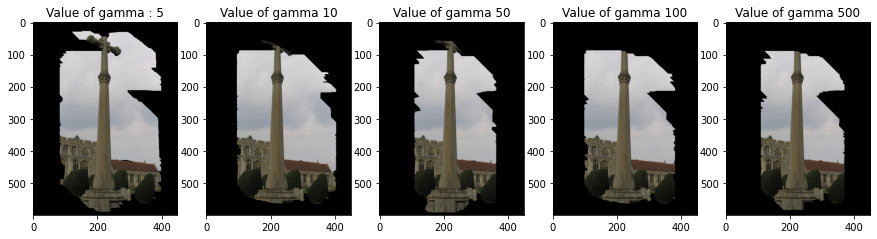

In [94]:
filename = '../images/cross.jpg'
img = cv2.imread(filename)
org=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,15))
plt.subplot(1,5,1)
plt.imshow(c_1)
plt.title("Value of gamma : 5")
plt.subplot(1,5,2)
plt.imshow(c_10)
plt.title("Value of gamma 10")
plt.subplot(1,5,3)
plt.imshow(c_50)
plt.title("Value of gamma 50")
plt.subplot(1,5,4)
plt.imshow(c_100)
plt.title("Value of gamma 100")
plt.subplot(1,5,5)
plt.imshow(c_500)
plt.title("Value of gamma 500")
plt.show()

For this image we can conclude that the best value of gamma is 50.

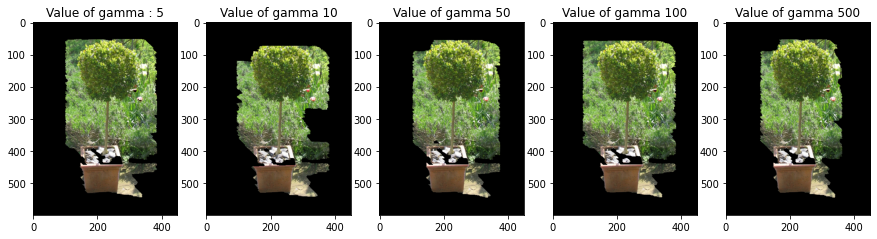

In [95]:
filename = '../images/bush.jpg'
img = cv2.imread(filename)
org=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,15))
plt.subplot(1,5,1)
plt.imshow(b_1)
plt.title("Value of gamma : 5")
plt.subplot(1,5,2)
plt.imshow(b_10)
plt.title("Value of gamma 10")
plt.subplot(1,5,3)
plt.imshow(b_50)
plt.title("Value of gamma 50")
plt.subplot(1,5,4)
plt.imshow(b_100)
plt.title("Value of gamma 100")
plt.subplot(1,5,5)
plt.imshow(b_500)
plt.title("Value of gamma 500")
plt.show()

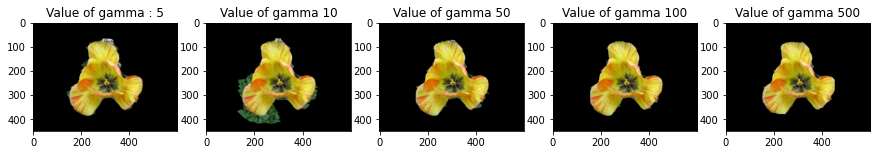

In [96]:
filename = '../images/flower.jpg'
img = cv2.imread(filename)
org=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,15))
plt.subplot(1,5,1)
plt.imshow(f_1)
plt.title("Value of gamma : 5")
plt.subplot(1,5,2)
plt.imshow(f_10)
plt.title("Value of gamma 10")
plt.subplot(1,5,3)
plt.imshow(f_50)
plt.title("Value of gamma 50")
plt.subplot(1,5,4)
plt.imshow(f_100)
plt.title("Value of gamma 100")
plt.subplot(1,5,5)
plt.imshow(f_500)
plt.title("Value of gamma 500")
plt.show()

### Conclusion: 
    The best value of Gamma is 50 .

### 4.The number of Gaussian mixture components 

We will see the results for 3 different values of k i.e. the number of gaussian mixture components i.e. 1,5 and 25.
Currently it is 5 so we will run first for 5 then 1 and then 25. Then we will plot the results and see.

In [8]:
filename = '../images/bool.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
b5=answers[0]
filename = '../images/scissors.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
s5=answers[0]
filename = '../images/fullmoon.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
f5=answers[0]

Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Starting The GMM modelling !  

/home/anjali/.local/lib/python3.8/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,


Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p


In [10]:
filename = '../images/bool.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
b1=answers[0]
filename = '../images/scissors.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
s1=answers[0]
filename = '../images/fullmoon.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
f1=answers[0]

Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut It

In [12]:
filename = '../images/bool.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
b25=answers[0]
filename = '../images/scissors.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
s25=answers[0]
filename = '../images/fullmoon.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
f25=answers[0]

Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p
Starting The GMM modelling !  

/home/anjali/.local/lib/python3.8/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (25). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,


Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p


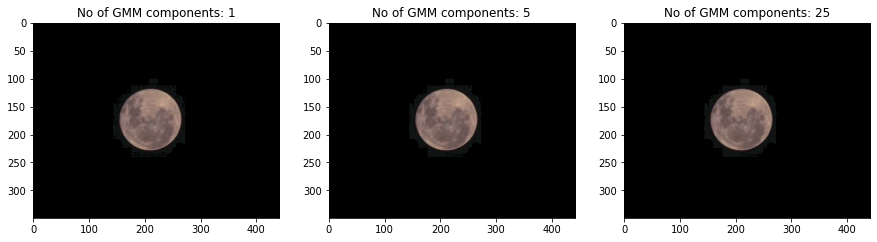

In [14]:

plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(f1)
plt.title("No of GMM components: 1")
plt.subplot(1,3,2)
plt.imshow(f5)
plt.title("No of GMM components: 5")
plt.subplot(1,3,3)
plt.imshow(f25)
plt.title("No of GMM components: 25")
plt.show()

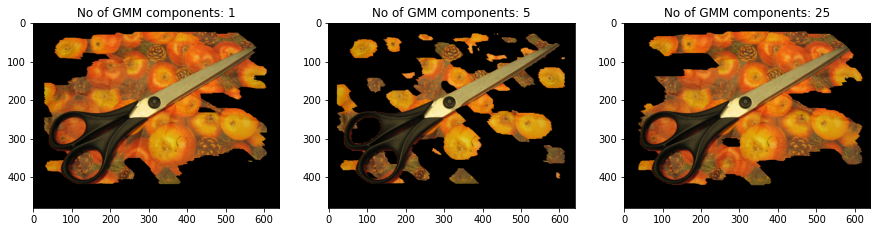

In [16]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(s1)
plt.title("No of GMM components: 1")
plt.subplot(1,3,2)
plt.imshow(s5)
plt.title("No of GMM components: 5")
plt.subplot(1,3,3)
plt.imshow(s25)
plt.title("No of GMM components: 25")
plt.show()

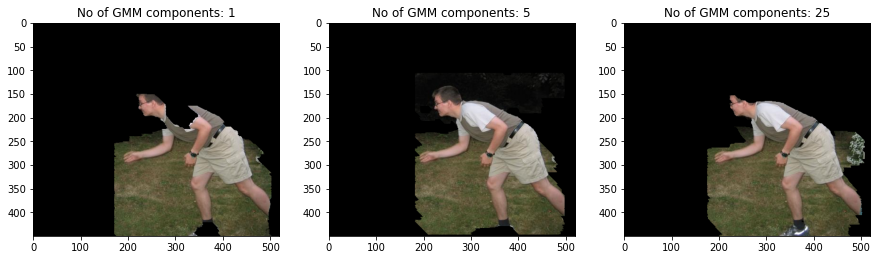

In [17]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(b1)
plt.title("No of GMM components: 1")
plt.subplot(1,3,2)
plt.imshow(b5)
plt.title("No of GMM components: 5")
plt.subplot(1,3,3)
plt.imshow(b25)
plt.title("No of GMM components: 25")
plt.show()

#### Conclusion:
    

From the above 3 examples we can see that if the number of components is very low, it may result in incorrectly categorizing many foreground pixels if the foreground object shows wide variation in color combination. At the same time if there are too many components there can be additional background pixels present in the segmentation of foreground object.Though we have choosen 5 for most of the iterations that we ran, the number of gmm components is a hyper parameter which has to be tuned and decided after experimenting.

### 5. Number of GMM iterations

In [19]:
filename = '../images/sheep.jpg'# Path to image file
#creating a list to store all the outputs
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
im1=answers[0]


Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Iteration Number: 1
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Iteration Number: 2
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p


In [14]:
#we are changing the num_iterations directly in the code
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
im2=answers[0]

Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Iteration Number: 1
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p


In [16]:
answers=list()
answers=run(filename,answers)
cv2.destroyAllWindows()
im3=answers[0]

Starting The GMM modelling !  Lets begin with the Iterations of Grab Cut
Its interactive grab Cut after each iteration we can add more fg bg points to further enhance our segmentation
Iteration Number: 0
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Iteration Number: 1
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Iteration Number: 2
Constructing Graph; Graph Constructed; Estimating Seg; Estimating Segmentation Performed Mincut Iteration  done;
Time for user interaction :p :p


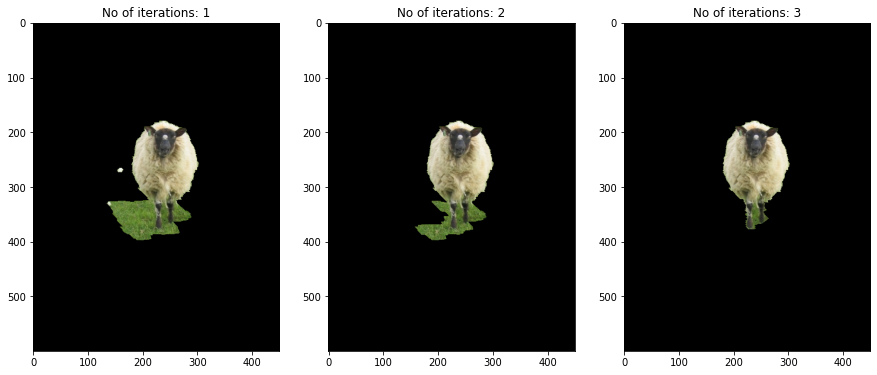

In [22]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(im1)
plt.title("No of iterations: 1")
plt.subplot(1,3,2)
plt.imshow(im2)
plt.title("No of iterations: 2")
plt.subplot(1,3,3)
plt.imshow(im3)
plt.title("No of iterations: 3")
plt.show()

-------------------------------------------------------------------------------------------------------------------

To conclude this Assignment we ran grab cut on many images and saw how human interaction and marking of bg and fg pixels makes our segmented object better and better.
For the experimentation part we experimented with the 4 factors and the results and conclusions have also been mentioned:
    Tight bounding Box VS Loose Bounding Box
    Various Color Spaces
    Value of Gamma
    No of GMM components
 
----------------------------------------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------------------------------